**Data loading**

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import log_loss
from datetime import datetime, timedelta
from scipy import sparse

In [3]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/RecSys/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/RecSys


In [ ]:
df = pd.read_csv('data.csv', usecols=['date_time', 'zone_id', 'banner_id', 'campaign_clicks', 'os_id', 'country_id', 'impressions', 'clicks'])
df.head()

In [4]:
target = df['clicks']
df.drop('clicks', axis=1, inplace=True)

In [5]:
df.shape

(15821472, 7)

**Data analysis**

In [6]:
df.isnull().sum().sum()

0

Пропущенных значений нет

In [7]:
df.describe()

,zone_id,banner_id,campaign_clicks,os_id,country_id,impressions
count,1.582147e+07,1.582147e+07,1.582147e+07,1.582147e+07,1.582147e+07,15821472.0
mean,8.152679e+01,3.816483e+02,6.238540e-01,1.840605e+00,4.346986e+00,1.0
std,1.632448e+02,3.959386e+02,9.249152e+00,1.530005e+00,4.317701e+00,0.0
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0
25%,1.400000e+01,5.200000e+01,0.000000e+00,1.000000e+00,0.000000e+00,1.0
50%,1.900000e+01,2.170000e+02,0.000000e+00,2.000000e+00,4.000000e+00,1.0
75%,6.000000e+01,6.110000e+02,0.000000e+00,3.000000e+00,7.000000e+00,1.0
max,3.443000e+03,1.632000e+03,8.290000e+02,1.000000e+01,1.600000e+01,1.0


Видим, что impressions - неинтересная фича, колонка заполнена исключительно единицами. Избавляемся от нее.

In [8]:
df.drop('impressions', axis=1, inplace=True)
df.head()

,date_time,zone_id,banner_id,campaign_clicks,os_id,country_id
0,2021-09-27 00:01:30.000000,0,0,0,0,0
1,2021-09-26 22:54:49.000000,1,1,0,0,1
2,2021-09-26 23:57:20.000000,2,2,3,0,0
3,2021-09-27 00:04:30.000000,3,3,0,1,1
4,2021-09-27 00:06:21.000000,4,4,0,1,0


Посмотрим на категориальные фичи

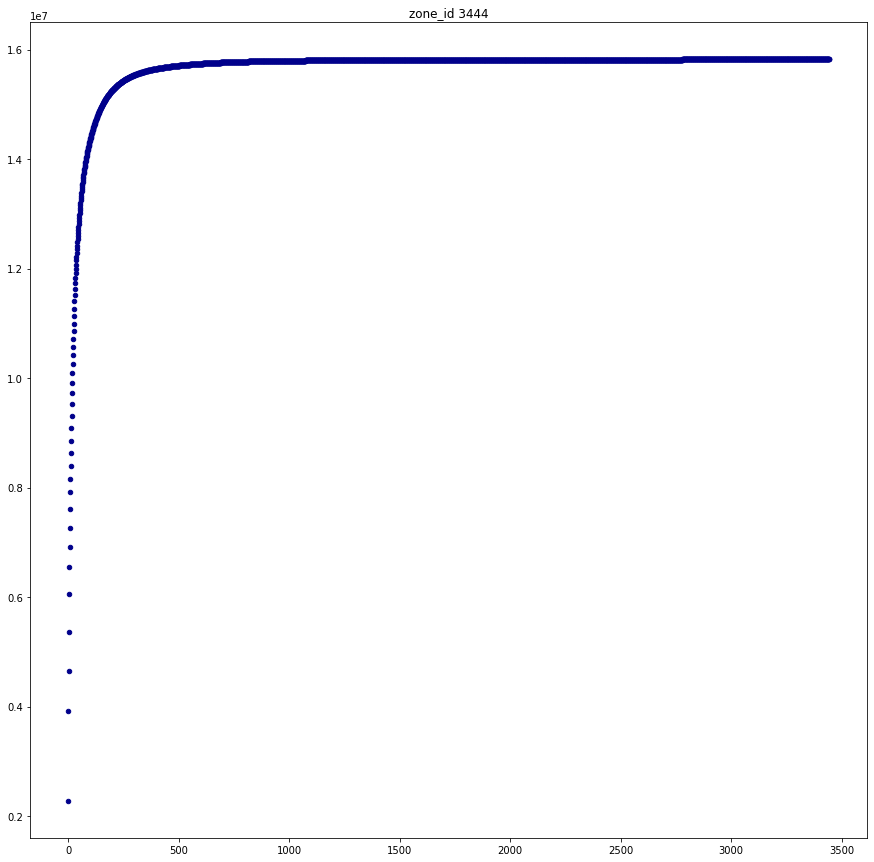

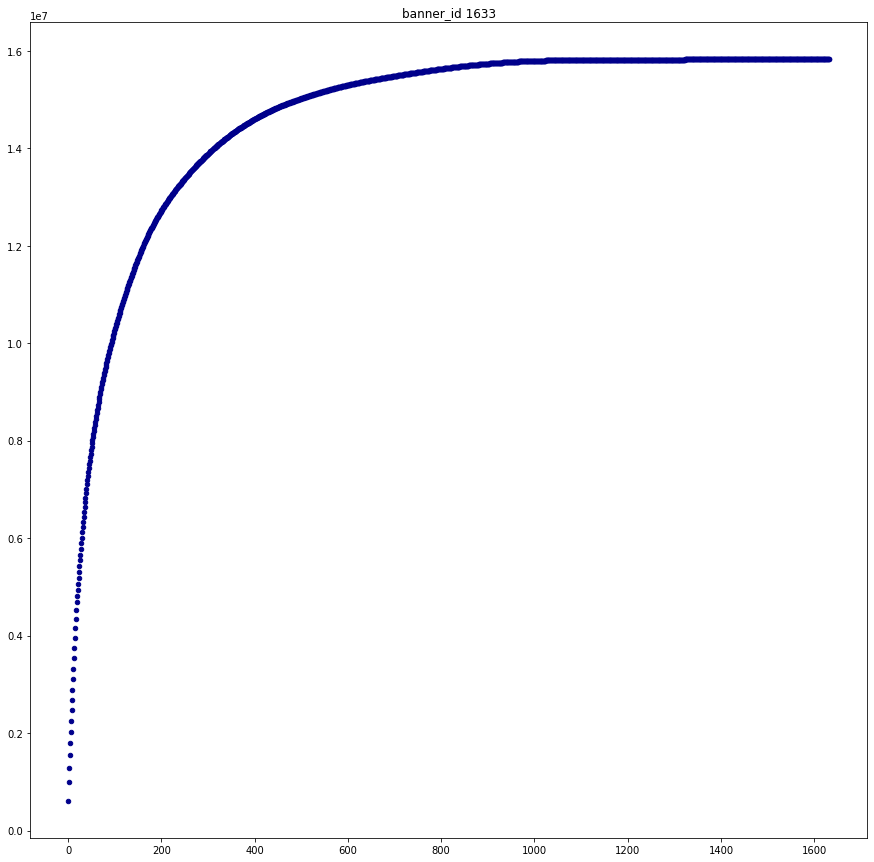

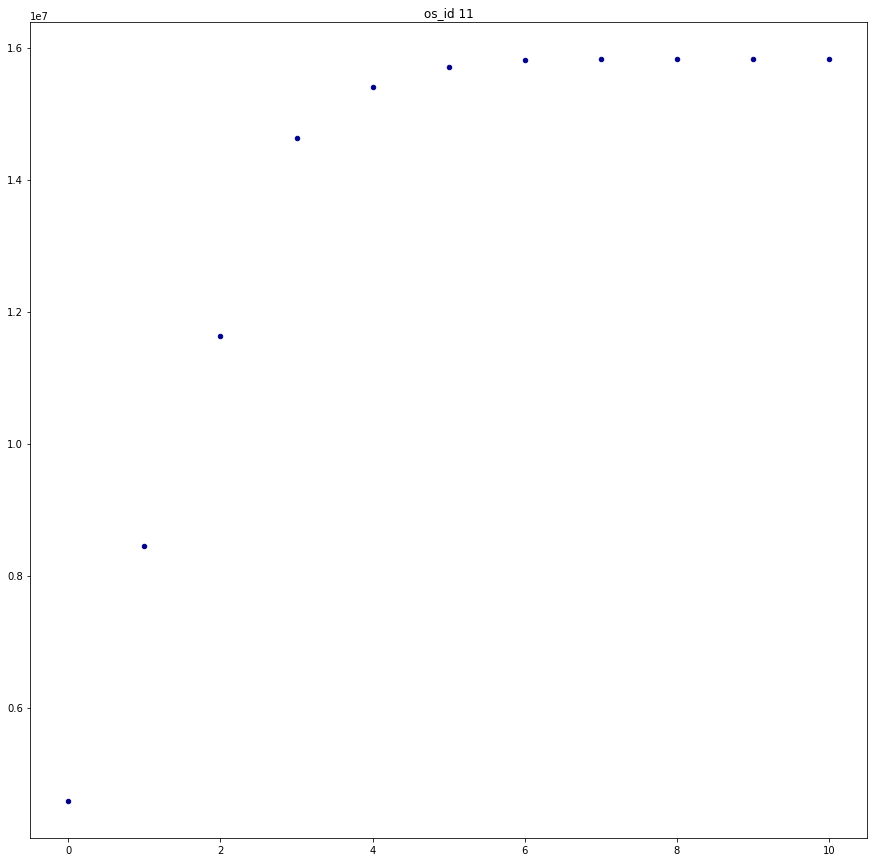

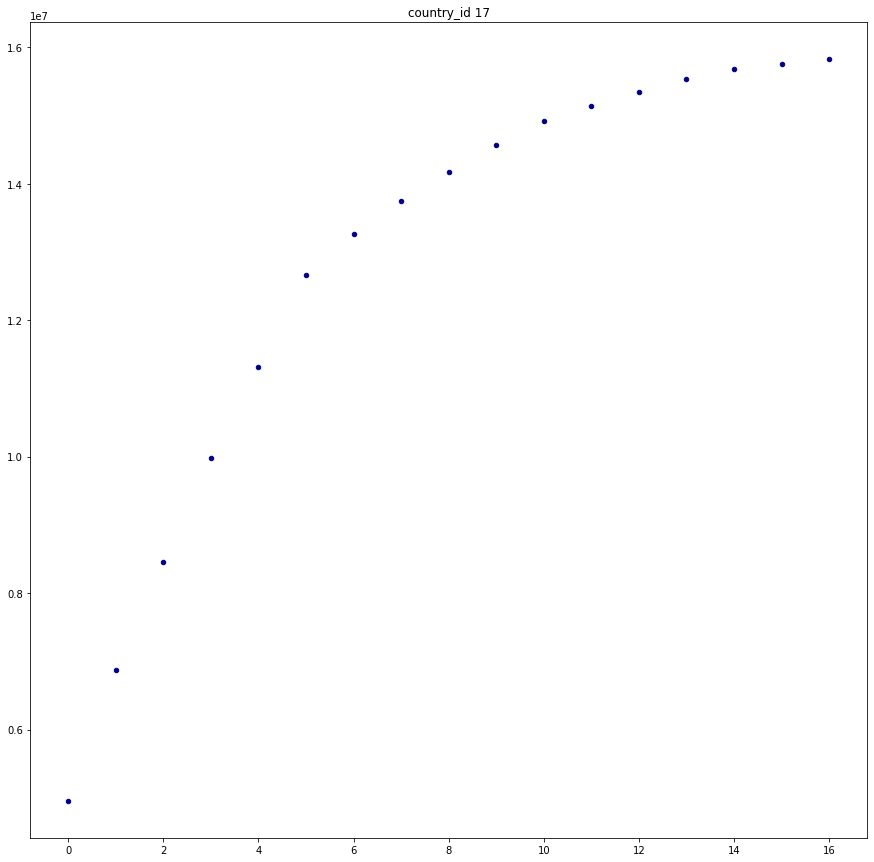

In [9]:
for feature in ['zone_id', 'banner_id', 'os_id', 'country_id']:
  plt.figure(figsize=(15, 15))
  plt.scatter(range(len(df[feature].unique())), df[feature].value_counts().cumsum(), color='darkblue', s=20)
  plt.title(f'{feature} {len(df[feature].unique())}')
  plt.show()

У зоны баннера и id самого баннера много уникальных значений (много зон, много баннеров), но большинство из них редкие. На операционные системы и страны, где уникальных значений мало, сейчас посмотрим внимательнее.

In [10]:
df['os_id'].value_counts()

2     4589979
0     3856798
1     3178693
4     3012541
3      759767
6      310346
5      111946
8        1273
7          99
9          25
10          5
Name: os_id, dtype: int64

7 из 11 операционных систем популярны, остальные скорее редкие, так их и закодируем

In [11]:
df['country_id'].value_counts()

0     4956393
5     1910054
6     1582705
7     1525569
1     1346321
3     1337392
15     603301
12     478038
9      439004
4      388801
10     356490
11     212245
8      210211
13     190855
14     138385
16      79166
2       66542
Name: country_id, dtype: int64

Везде живет достаточно людей, страны закодируем как есть. Теперь посмотрим на время (а именно на дни): 

In [12]:
days = df['date_time'].apply(lambda x: x[:10])
days.value_counts()

2021-09-26    3102610
2021-09-29    2420588
2021-09-27    2367303
2021-09-28    2307355
2021-10-02    2128978
2021-09-30    1851189
2021-10-01    1643448
2021-09-01          1
Name: date_time, dtype: int64

Мы видим неделю в конце сентября-начале октября и один лишний день, его выкинем. Ясно, что нельзя использовать с такой обучающей выборкой день недели или месяц, потому что по ним нет повторяемости в разные недели/года. 

**Feature engineering**

Добавим данные времени (сначала все)

In [13]:
def get_features(df):
  # время
  hour = df['date_time'].apply(lambda x: int(x[11:13]))
  df['hour'] = hour
  df['daytime'] = hour // 6

  # заменяем разные редкие категории на общую
  zone_mask = df['zone_id'].isin(df.groupby('zone_id')['date_time'].count().sort_values(key=lambda x: -x).index[250:])
  df.loc[zone_mask, 'zone_id'] = -1

  banner_mask = df['banner_id'].isin(df.groupby('banner_id')['date_time'].count().sort_values(key=lambda x: -x).index[600:])
  df.loc[banner_mask, 'banner_id'] = -1

  os_mask = df['os_id'].isin(df.groupby('os_id')['date_time'].count().sort_values(key=lambda x: -x).index[7:])
  df.loc[os_mask, 'os_id'] = -1


  # добавляем интеракции - зона + операционка, баннер + час, баннер + время суток, баннер + операционка (много выходит, да)

  df['zone+os'] = df['zone_id'].astype(str) + '+' + df['os_id'].astype(str)
  df['hour+banner'] = df['hour'].astype(str) + '+' + df['banner_id'].astype(str)
  df['daytime+banner'] = df['daytime'].astype(str) + '+' + df['banner_id'].astype(str)
  df['os+banner'] = df['os_id'].astype(str) + '+' + df['banner_id'].astype(str)

  # Тут можно было бы помучиться с возможностью учесть таргет - клики - за прошедшнее время,
  # коль скоро все равно предсказываем будущее (и cv должна быть соответствующая).
  # И еще для категориальных фичей с кучей значений неплохо подошел бы target encoding. Но имеем то, что имеем.

In [14]:
get_features(df)
df

,date_time,zone_id,banner_id,campaign_clicks,os_id,country_id,hour,daytime,zone+os,hour+banner,daytime+banner,os+banner
0,2021-09-27 00:01:30.000000,0,0,0,0,0,0,0,0+0,0+0,0+0,0+0
1,2021-09-26 22:54:49.000000,1,1,0,0,1,22,3,1+0,22+1,3+1,0+1
2,2021-09-26 23:57:20.000000,2,2,3,0,0,23,3,2+0,23+2,3+2,0+2
3,2021-09-27 00:04:30.000000,3,3,0,1,1,0,0,3+1,0+3,0+3,1+3
4,2021-09-27 00:06:21.000000,4,4,0,1,0,0,0,4+1,0+4,0+4,1+4
...,...,...,...,...,...,...,...,...,...,...,...,...
15821467,2021-10-02 15:51:35.000000,146,530,0,2,9,15,2,146+2,15+530,2+530,2+530
15821468,2021-09-27 22:03:14.000000,12,22,0,1,6,22,3,12+1,22+22,3+22,1+22
15821469,2021-10-02 17:41:10.000000,12,1236,0,2,0,17,2,12+2,17+1236,2+1236,2+1236
15821470,2021-09-29 00:39:32.000000,-1,21,0,0,0,0,0,-1+0,0+21,0+21,0+21


In [ ]:
df.to_csv('new_data.csv', index=False)
target.to_csv('target.csv', index=False)

**Create model**

Будем обучаться по первым пяти дням, валидироваться по шестому, предсказывать седьмой

In [4]:
df = pd.read_csv('new_data.csv')
df

,date_time,zone_id,banner_id,campaign_clicks,os_id,country_id,hour,daytime,zone+os,hour+banner,daytime+banner,os+banner
0,2021-09-27 00:01:30.000000,0,0,0,0,0,0,0,0+0,0+0,0+0,0+0
1,2021-09-26 22:54:49.000000,1,1,0,0,1,22,3,1+0,22+1,3+1,0+1
2,2021-09-26 23:57:20.000000,2,2,3,0,0,23,3,2+0,23+2,3+2,0+2
3,2021-09-27 00:04:30.000000,3,3,0,1,1,0,0,3+1,0+3,0+3,1+3
4,2021-09-27 00:06:21.000000,4,4,0,1,0,0,0,4+1,0+4,0+4,1+4
...,...,...,...,...,...,...,...,...,...,...,...,...
15821467,2021-10-02 15:51:35.000000,146,530,0,2,9,15,2,146+2,15+530,2+530,2+530
15821468,2021-09-27 22:03:14.000000,12,22,0,1,6,22,3,12+1,22+22,3+22,1+22
15821469,2021-10-02 17:41:10.000000,12,1236,0,2,0,17,2,12+2,17+1236,2+1236,2+1236
15821470,2021-09-29 00:39:32.000000,-1,21,0,0,0,0,0,-1+0,0+21,0+21,0+21


In [5]:
target = pd.read_csv('target.csv')
target

,clicks
0,1
1,1
2,1
3,1
4,1
...,...
15821467,0
15821468,0
15821469,0
15821470,0


Мы, разумеется, будем использовать разреженные матрицы

In [6]:
def get_sparse(df_train, df_val, df_test):
  ohe = OneHotEncoder(handle_unknown='ignore')
  scaler = StandardScaler()
  features = ['zone_id', 'banner_id', 'os_id', 'country_id', 'hour', 'daytime',
              'zone+os', 'hour+banner', 'daytime+banner', 'os+banner']
  to_train = []
  to_val = []
  to_test = []
  for feature in features:
    to_train.append(ohe.fit_transform(df_train[[feature]]))
    to_val.append(ohe.transform(df_val[[feature]]))
    to_test.append(ohe.transform(df_test[[feature]]))


  to_train.append(sparse.csr_matrix(scaler.fit_transform(df_train[['campaign_clicks']])))
  to_val.append(sparse.csr_matrix(scaler.transform(df_val[['campaign_clicks']])))
  to_test.append(sparse.csr_matrix(scaler.transform(df_test[['campaign_clicks']])))


  X_train = sparse.hstack(to_train)
  X_val = sparse.hstack(to_val)
  X_test = sparse.hstack(to_test)


  X_train = X_train.tocsr()
  X_val = X_val.tocsr()
  X_test = X_test.tocsr()
  return X_train, X_val, X_test

In [7]:
df_train, y_train = df[df['date_time'] < '2021-10-01'], target[df['date_time'] < '2021-10-01']
df_val, y_val = df[(df['date_time'] >= '2021-10-01') & (df['date_time'] < '2021-10-02')], target[(df['date_time'] >= '2021-10-01') & (df['date_time'] < '2021-10-02')]
df_test, y_test = df[df['date_time'] > '2021-10-02'], target[df['date_time'] > '2021-10-02']  

In [8]:
X_train, X_val, X_test = get_sparse(df_train, df_val, df_test)

In [9]:
print(X_train.shape, X_val.shape, X_test.shape)

(12049046, 18236) (1643448, 18236) (2128978, 18236)


In [9]:
def create_model(C, X_train, y_train):
  clf = LogisticRegression(C=C, solver='liblinear')
  clf.fit(X_train, y_train)
  return clf

Наконец пообучаем модели, пройдемся по разным C

In [10]:
scores = []
for C in [10 ** a for a in range(-3, 4)]:
  clf = create_model(C, X_train, y_train.values.ravel())
  y_pred = clf.predict_proba(X_val)[:, 1]
  score = log_loss(y_val, y_pred)
  scores.append(score)
  print(C, score)

0.001 0.15529542148397862
0.01 0.15179193426033685
0.1 0.1511850617834189
1 0.15181898532023955
10 0.15317894577978655
100 0.1548258581993187
1000 0.15425492559435774


Лучшее С - 0.1 

In [11]:
clf = create_model(0.1, X_train, y_train)
y_pred = clf.predict_proba(X_test)[:, 1]
score = log_loss(y_test, y_pred)
print(score)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.13477030772001006
